In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix
from sklearn import base
from scipy.stats import norm
import random as rnd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import time
from tqdm import tqdm
from random import seed
from random import randrange
from csv import reader
from math import sqrt


In [2]:
df=pd.read_csv("/content/in-vehicle-coupon-recommendation.csv")

## Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [4]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [5]:
(df.isna().sum()/len(df)).sort_values(ascending=False)

car                     0.991485
CoffeeHouse             0.017108
Restaurant20To50        0.014901
CarryAway               0.011905
RestaurantLessThan20    0.010249
Bar                     0.008436
destination             0.000000
passanger               0.000000
direction_opp           0.000000
direction_same          0.000000
toCoupon_GEQ25min       0.000000
toCoupon_GEQ15min       0.000000
toCoupon_GEQ5min        0.000000
income                  0.000000
occupation              0.000000
education               0.000000
has_children            0.000000
maritalStatus           0.000000
age                     0.000000
gender                  0.000000
expiration              0.000000
coupon                  0.000000
time                    0.000000
temperature             0.000000
weather                 0.000000
Y                       0.000000
dtype: float64

In [6]:
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.car.unique()

array([nan, 'Scooter and motorcycle', 'crossover', 'Mazda5',
       'do not drive', 'Car that is too old to install Onstar :D'],
      dtype=object)

# Missing Values Analysis

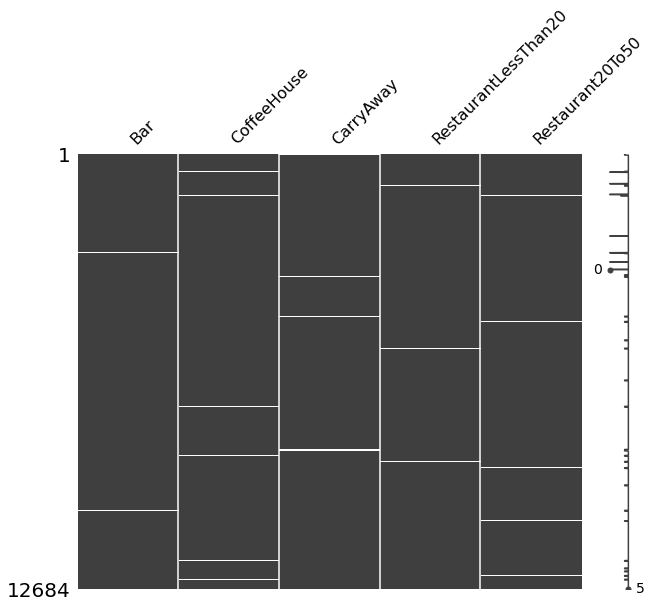

In [8]:
na_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
na_df = df[na_columns]
msno.matrix(na_df, figsize=(10, 8))
plt.show()

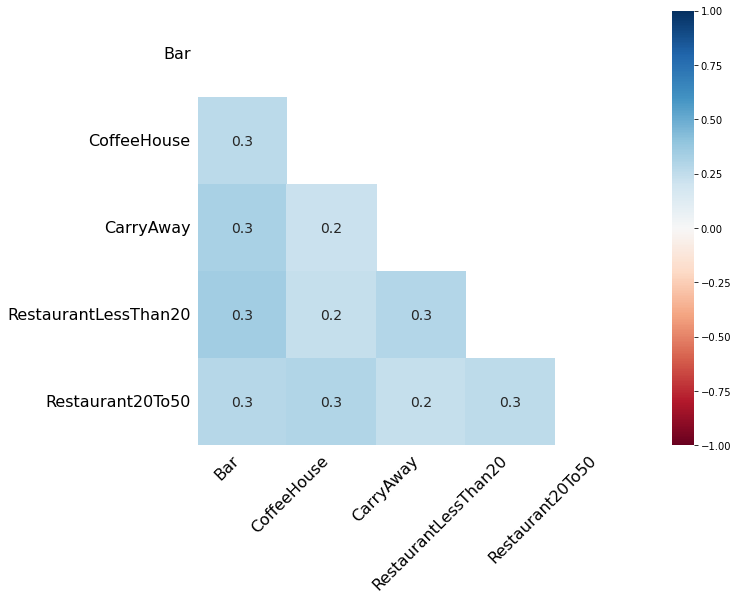

In [9]:
msno.heatmap(na_df, figsize=(10, 8));


In [10]:
df.iloc[:,(df.dtypes=="int64").values].nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

In [11]:
df.drop(columns=['toCoupon_GEQ5min','car'], inplace=True)


In [12]:
clean_df = df.copy()


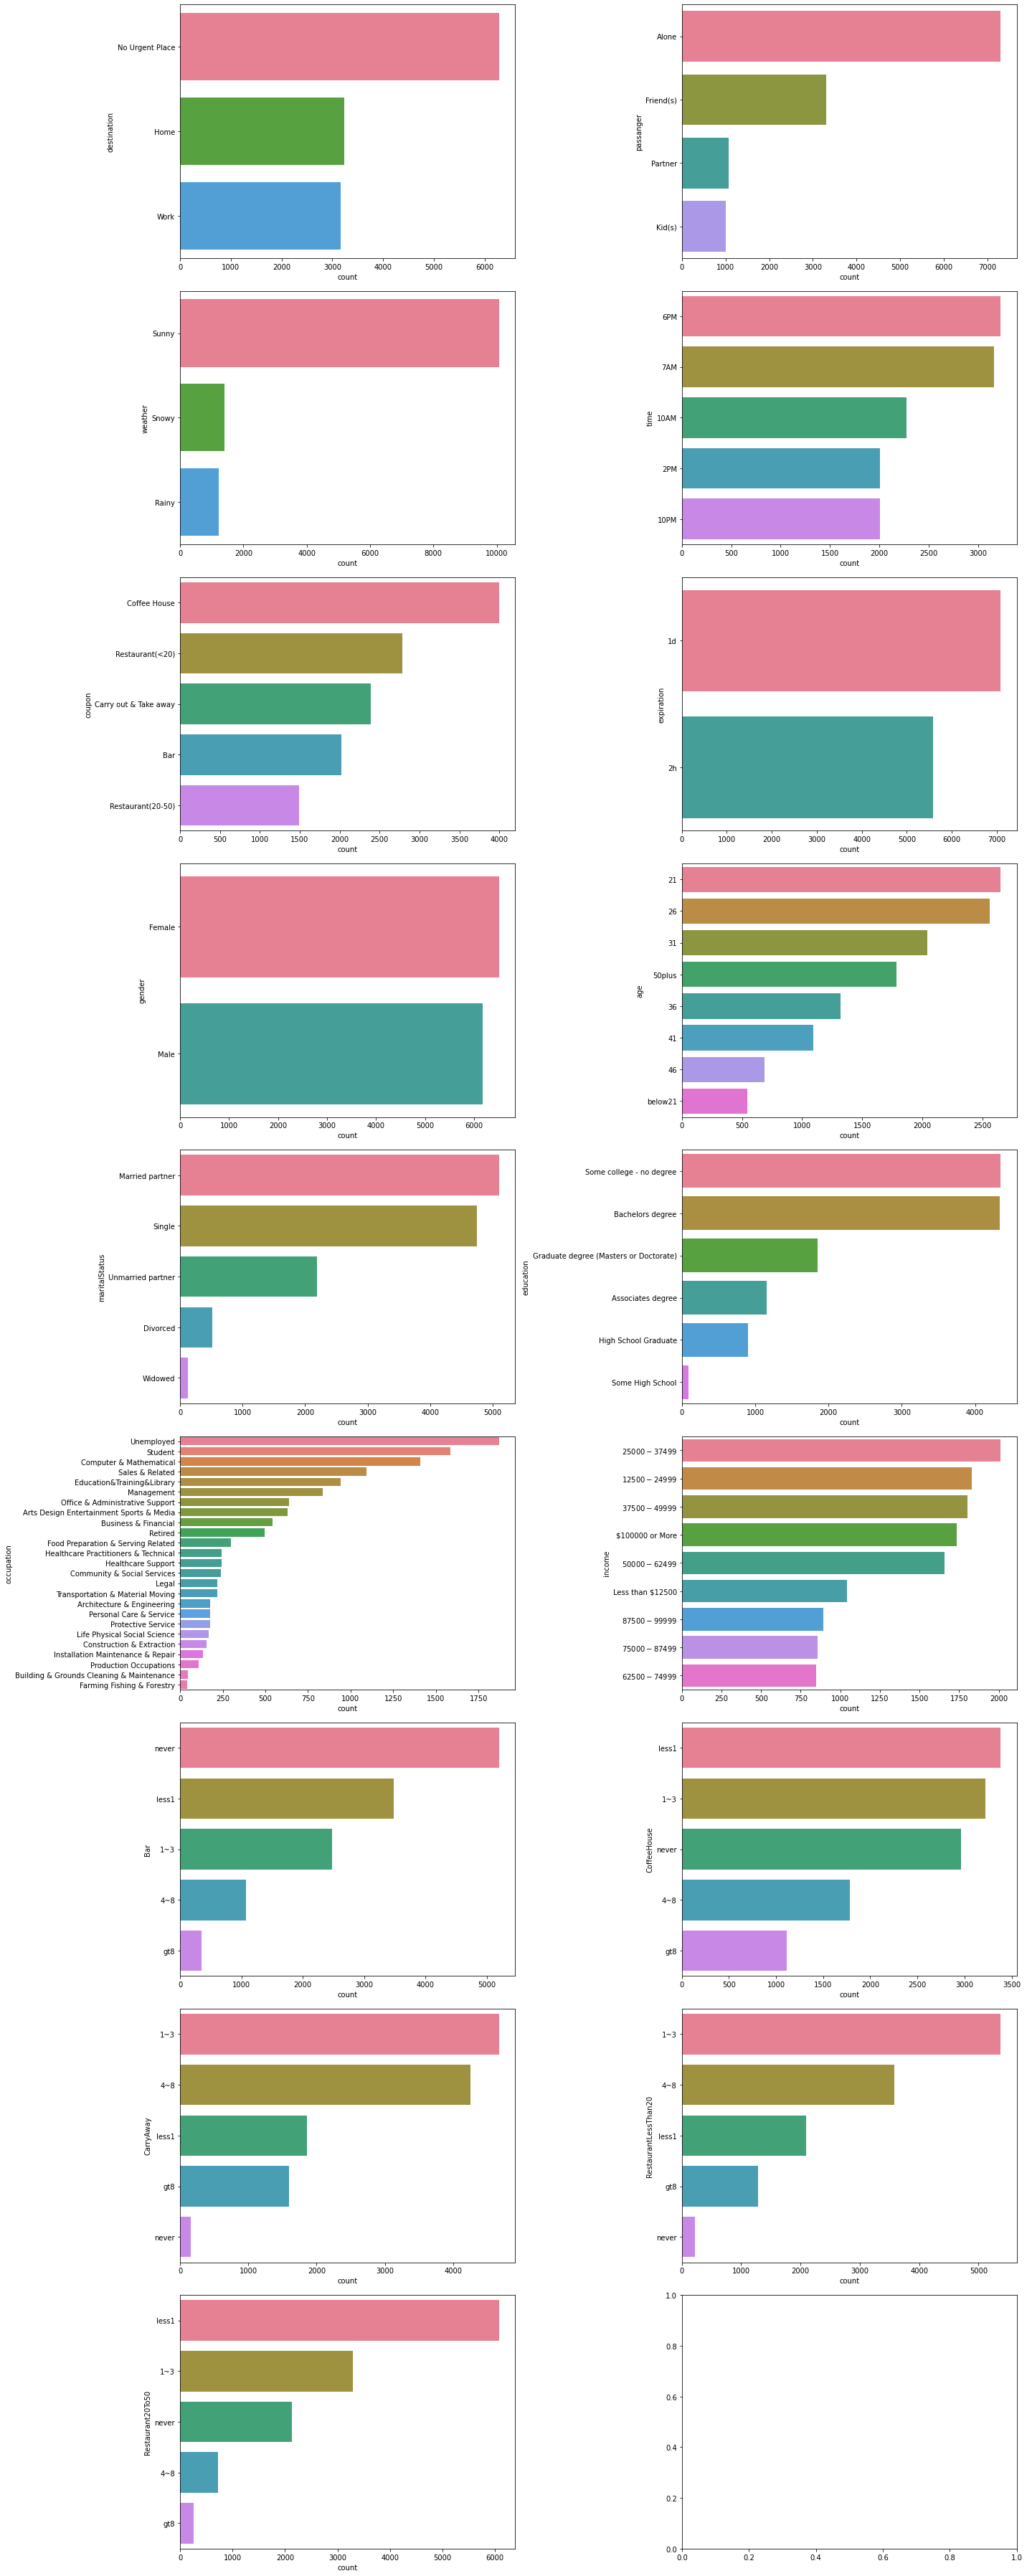

In [13]:
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, clean_df.select_dtypes('object').columns):
    sns.countplot(y=col, data=clean_df, ax=ax, 
                  palette="husl", order=clean_df[col].value_counts().index);

plt.tight_layout()
plt.show()

In [14]:
frequency_map = {
    'never': 0,
    'less1': 1,
    '1~3': 2,
    '4~8': 3,
    'gt8': 4
}
age_map = {
    'below21': 0,
    '21': 1,
    '26': 2,
    '31': 3,
    '36': 4,
    '41': 5,
    '46': 6,
    '50plus': 7
}
income_map = {
    'Less than $12500': 0,
    '$12500 - $24999': 1,
    '$25000 - $37499': 2,
    '$37500 - $49999': 3,
    '$50000 - $62499': 4,
    '$62500 - $74999': 5,
    '$75000 - $87499': 6,
    '$87500 - $99999': 7,
    '$100000 or More': 8
}

In [15]:
frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20', 
                  'CarryAway', 'CoffeeHouse', 'Bar']

In [16]:
for col in frequency_cols:
    clean_df[col] = clean_df[col].map(frequency_map)
clean_df.age = clean_df.age.map(age_map)
clean_df.income = clean_df.income.map(income_map)

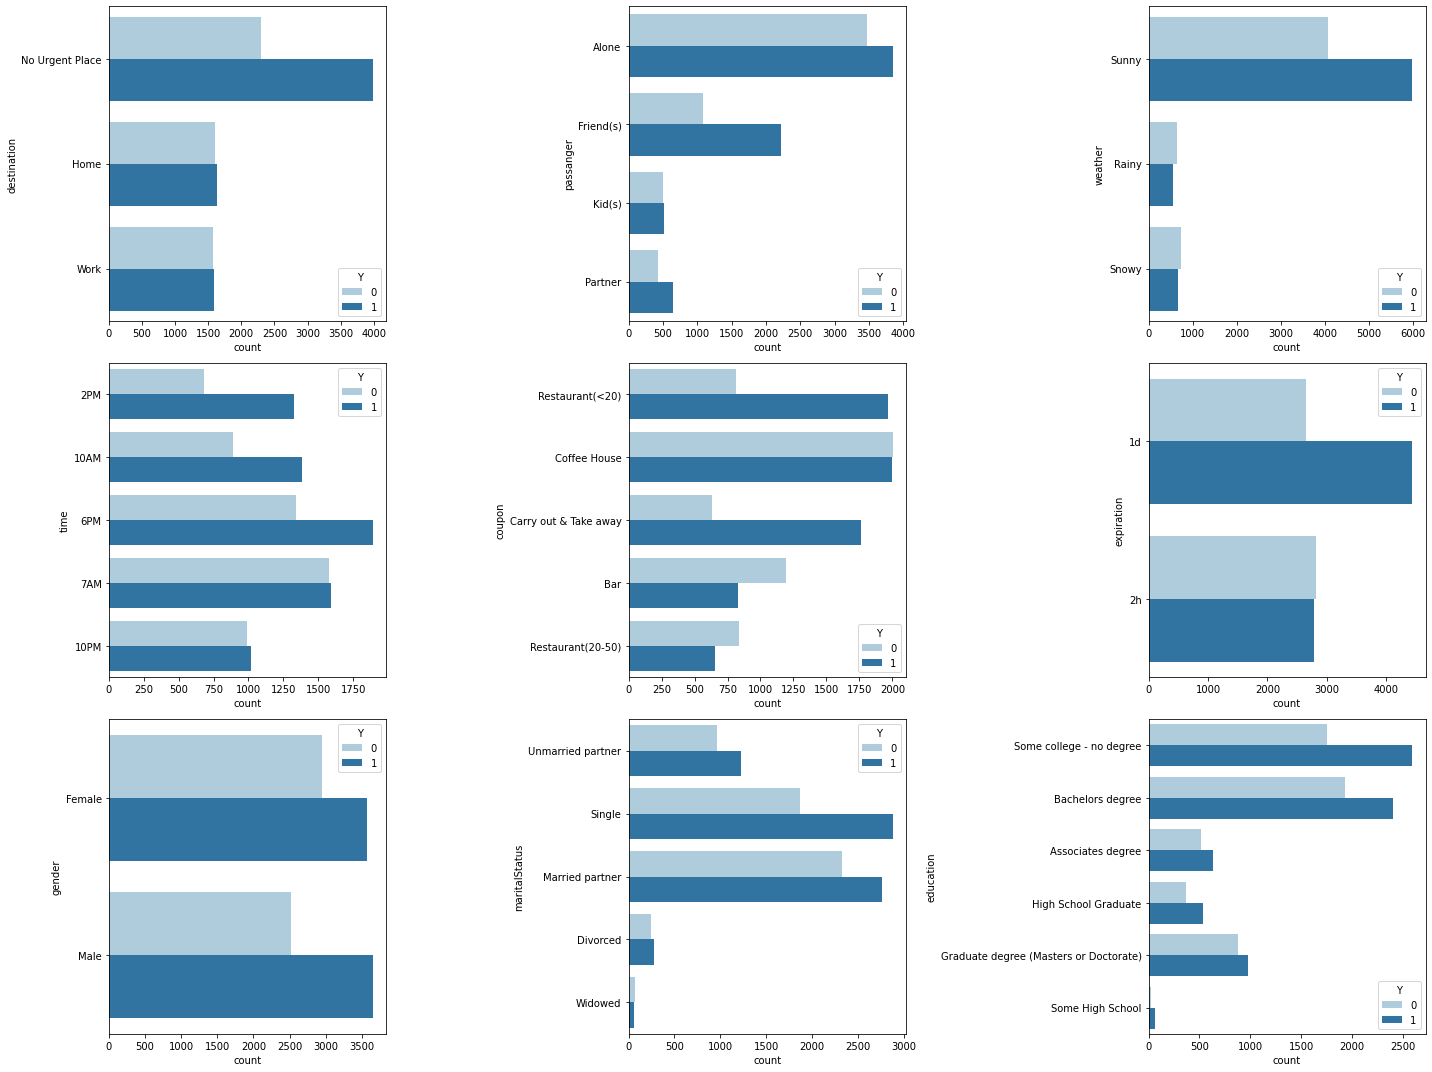

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for ax, col in zip(axes, ['destination', 'passanger', 'weather', 'time', 
                          'coupon', 'expiration', 'gender', 'maritalStatus',
                          'education']):
    sns.countplot(y=col, hue='Y', data=clean_df, ax=ax, palette='Paired')
plt.tight_layout()
plt.show()

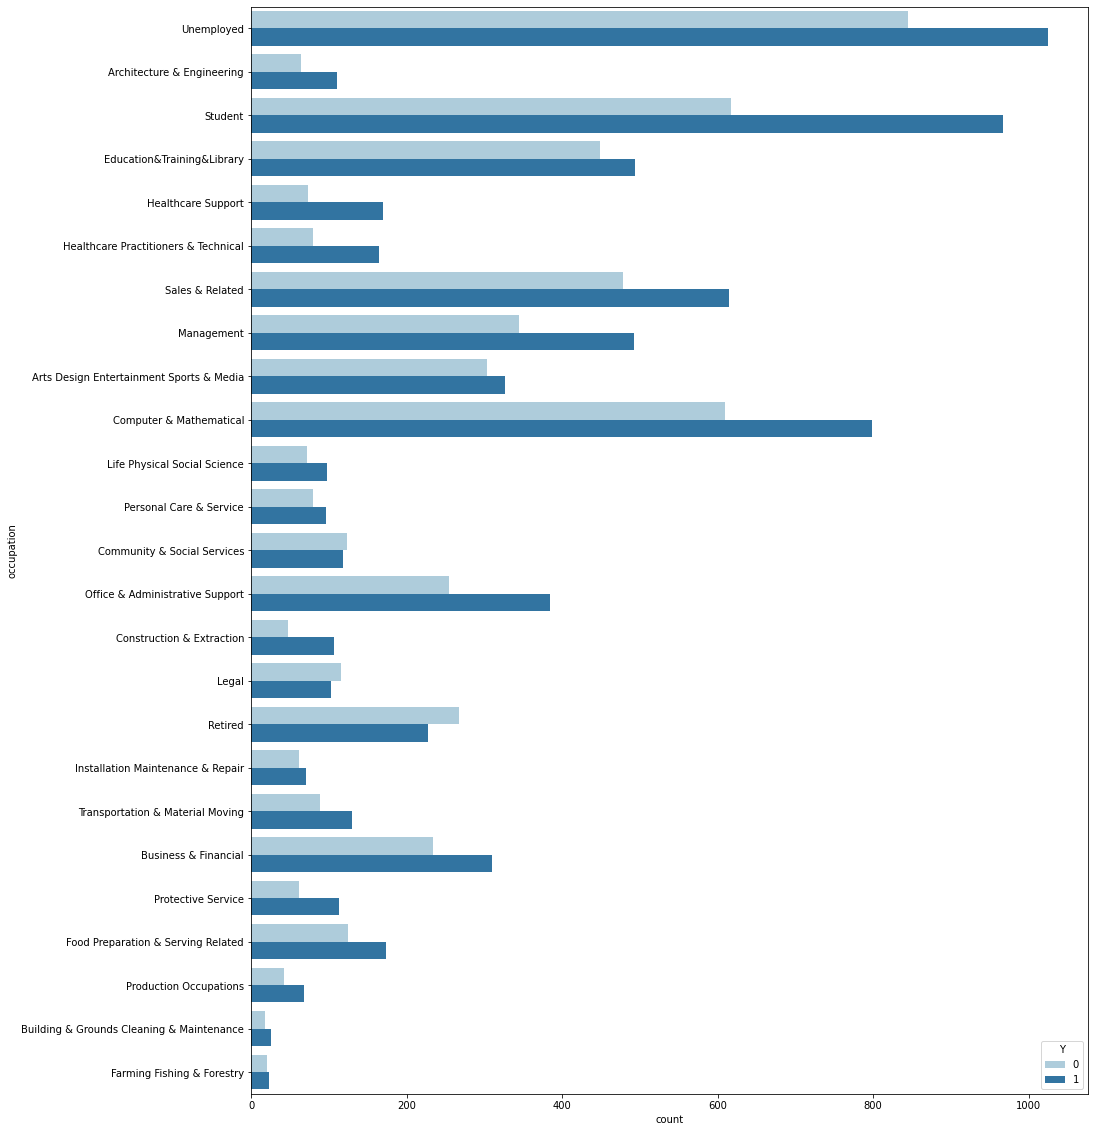

In [18]:
plt.subplots(figsize=(15, 20))
sns.countplot(y ='occupation', hue='Y', data=clean_df, palette='Paired');
plt.show()

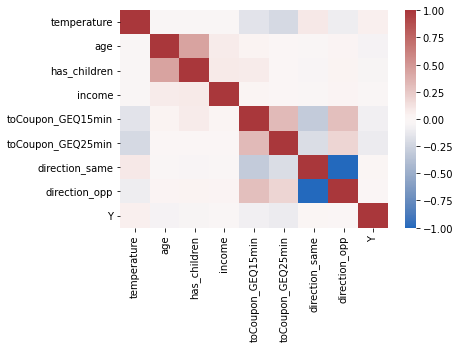

In [19]:
cmap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(clean_df.select_dtypes('int64', 'float64').corr(), cmap=cmap)
plt.show()

In [20]:
clean_df.drop(columns=['direction_opp'], inplace=True)


In [21]:
clean_df['distance'] = None
clean_df.loc[clean_df['toCoupon_GEQ15min'] == 0, 'distance'] = 0
clean_df.loc[(clean_df['toCoupon_GEQ15min'] == 1) & \
             (clean_df['toCoupon_GEQ25min'] == 0), 'distance'] = 1
clean_df.loc[clean_df['toCoupon_GEQ25min'] == 1, 'distance'] = 2
clean_df.distance.isna().sum()

0

In [22]:
clean_df.distance = clean_df.distance.astype('int64')
clean_df.distance.value_counts()


1    5611
0    5562
2    1511
Name: distance, dtype: int64

In [23]:
clean_df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)


In [24]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   destination           12684 non-null  object 
 1   passanger             12684 non-null  object 
 2   weather               12684 non-null  object 
 3   temperature           12684 non-null  int64  
 4   time                  12684 non-null  object 
 5   coupon                12684 non-null  object 
 6   expiration            12684 non-null  object 
 7   gender                12684 non-null  object 
 8   age                   12684 non-null  int64  
 9   maritalStatus         12684 non-null  object 
 10  has_children          12684 non-null  int64  
 11  education             12684 non-null  object 
 12  occupation            12684 non-null  object 
 13  income                12684 non-null  int64  
 14  Bar                   12577 non-null  float64
 15  CoffeeHouse        

In [25]:
clean_df.head(1)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same,Y,distance
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,1,Unmarried partner,...,Unemployed,3,0.0,0.0,NaN,3.0,2.0,0,1,0


In [26]:
clean_df.has_children = clean_df.has_children.astype(str)
clean_df.direction_same = clean_df.direction_same.astype(str)

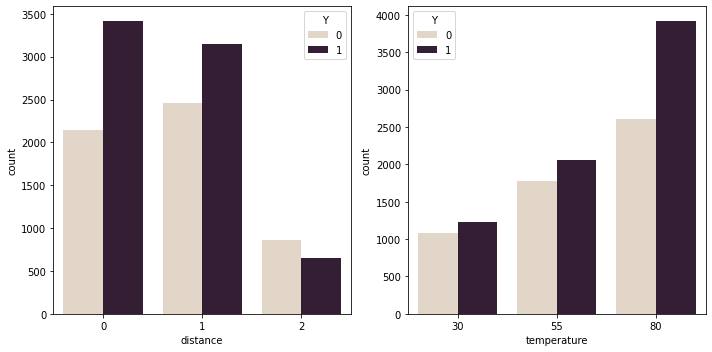

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

for ax, col in zip(axes, ['distance', 'temperature']):
    sns.countplot(x=col, hue='Y', data=clean_df, 
                  ax=ax, palette="ch:.25");

plt.tight_layout()
plt.show()

In [28]:
clean_df.isna().sum()


destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
direction_same            0
Y                         0
distance                  0
dtype: int64

In [29]:
clean_df.to_csv('clean_df.csv', index=False)


In [30]:
clean_df["passanger"]

0            Alone
1        Friend(s)
2        Friend(s)
3        Friend(s)
4        Friend(s)
           ...    
12679      Partner
12680        Alone
12681        Alone
12682        Alone
12683        Alone
Name: passanger, Length: 12684, dtype: object

In [31]:
X = clean_df.drop(columns=['Y'])
y = clean_df.Y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

##Approach 1

In [32]:
X_train

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same,distance
5282,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,6,Unmarried partner,...,Some college - no degree,Transportation & Material Moving,1,0.0,1.0,2.0,1.0,1.0,0,1
11372,No Urgent Place,Friend(s),Snowy,30,2PM,Restaurant(<20),1d,Female,1,Married partner,...,Associates degree,Unemployed,4,0.0,2.0,2.0,2.0,2.0,0,0
11650,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Male,1,Single,...,Some college - no degree,Student,0,1.0,1.0,1.0,2.0,2.0,1,0
8733,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Female,3,Married partner,...,Some college - no degree,Arts Design Entertainment Sports & Media,8,1.0,1.0,4.0,3.0,1.0,0,2
7663,No Urgent Place,Alone,Sunny,80,10AM,Coffee House,1d,Male,4,Single,...,Some college - no degree,Construction & Extraction,4,0.0,0.0,2.0,1.0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,No Urgent Place,Alone,Rainy,55,10AM,Bar,1d,Female,3,Married partner,...,Bachelors degree,Student,3,0.0,1.0,4.0,3.0,1.0,0,1
905,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,3,Unmarried partner,...,Associates degree,Education&Training&Library,4,0.0,0.0,3.0,NaN,0.0,0,1
5192,Work,Alone,Sunny,55,7AM,Coffee House,1d,Female,7,Single,...,Graduate degree (Masters or Doctorate),Education&Training&Library,1,0.0,0.0,3.0,3.0,1.0,0,1
12172,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Female,3,Single,...,Associates degree,Arts Design Entertainment Sports & Media,6,NaN,1.0,4.0,2.0,1.0,1,0


In [33]:
X_train_a = X_train.copy()
X_test_a = X_test.copy()


In [34]:
strong_predictors = ['destination', 'passanger', 'weather', 'time', 'coupon',
            'expiration', 'maritalStatus', 'education',
            'occupation', 'direction_same']
for col in strong_predictors:
    # create frequency encoder
    freq_encoder = X_train_a.groupby(col).size() / len(X_train_a)
    # fit_transform for X_train
    X_train_a[col + '_freq'] = X_train_a[col].apply(lambda x: freq_encoder[x])
    # transform for X_test
    X_test_a[col + '_freq'] = X_test_a[col].apply(lambda x: freq_encoder[x])

In [35]:
X_test_a

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,destination_freq,passanger_freq,weather_freq,time_freq,coupon_freq,expiration_freq,maritalStatus_freq,education_freq,occupation_freq,direction_same_freq
12493,Home,Alone,Snowy,30,10PM,Coffee House,2h,Female,2,Unmarried partner,...,0.258007,0.577215,0.112546,0.158372,0.315955,0.444466,0.171873,0.342761,0.049966,0.78368
7508,No Urgent Place,Friend(s),Sunny,80,2PM,Restaurant(20-50),2h,Female,5,Unmarried partner,...,0.493446,0.258500,0.792550,0.156795,0.115896,0.444466,0.171873,0.342761,0.148812,0.78368
10212,No Urgent Place,Partner,Sunny,55,2PM,Bar,1d,Female,3,Married partner,...,0.493446,0.083966,0.792550,0.156795,0.158273,0.555534,0.402681,0.342761,0.110377,0.78368
7714,No Urgent Place,Friend(s),Sunny,30,10PM,Restaurant(<20),2h,Female,3,Single,...,0.493446,0.258500,0.792550,0.158372,0.219671,0.444466,0.374889,0.340495,0.148812,0.78368
2403,Work,Alone,Sunny,55,7AM,Bar,1d,Female,7,Married partner,...,0.248546,0.577215,0.792550,0.248546,0.158273,0.555534,0.402681,0.342761,0.016458,0.78368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,No Urgent Place,Friend(s),Snowy,30,10AM,Carry out & Take away,1d,Male,3,Married partner,...,0.493446,0.258500,0.112546,0.180152,0.190204,0.555534,0.402681,0.145856,0.042870,0.78368
6313,Home,Alone,Sunny,80,6PM,Coffee House,2h,Female,3,Married partner,...,0.258007,0.577215,0.792550,0.256135,0.315955,0.444466,0.402681,0.145856,0.110377,0.78368
7305,No Urgent Place,Alone,Sunny,80,10AM,Coffee House,1d,Female,2,Single,...,0.493446,0.577215,0.792550,0.180152,0.315955,0.555534,0.374889,0.340495,0.049966,0.78368
4182,Home,Alone,Sunny,55,10PM,Carry out & Take away,1d,Male,2,Single,...,0.258007,0.577215,0.792550,0.158372,0.190204,0.555534,0.374889,0.090766,0.148812,0.78368


In [36]:
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):
    """
    This object contains a target encoder for a training set which should have
    both X and y. 
    
    Arguments
    ---------
    feature:          string. Name of the feature in the training set.
    target:           string. Name of the target in the training set.
    n_fold:           default 5. Number of folds to use in KFold.
    verbose:          bool, default True. If set to True, the correlation between the 
                      feature and the target will be calculated and printed out.
    discard_original: bool,, default False. If set to True, the feature column will be 
                      deleted from the training set.
                      
    Example
    ---------
    train_target_encoder = KFoldTargetEncoderTrain(feature='A', target='target')
    new_train = train_target_encoder.fit_transform(train)
    """
    def __init__(self, feature, target, n_fold=5, verbose=True, discard_original=False):

        self.feature = feature
        self.target = target
        self.n_fold = n_fold
        self.verbose = verbose
        self.discard_original = discard_original

    def fit(self, X, y=None):
        return self

    def transform(self,X):
        """
        Transform the original training set. Notice this function can only encode 
        one feature once.
        
        Arguments:
        ----------
        X: A pandas DataFrame which should include both the feature and the target.
        
        Output:
        X: A pandas DataFrame with the target encoding.
        """
        
        # notice this function can only encode one feature at a time
        assert(type(self.feature) == str)
        assert(type(self.target) == str)
        assert(self.feature in X.columns)
        assert(self.target in X.columns)

        mean_of_target = X[self.target].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=1)
        # create the target encoding
        col_mean_name = self.feature + '_target'
        X[col_mean_name] = np.nan

        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            X.loc[X.index[val_index], col_mean_name] = \
            X_val[self.feature].map(X_train.groupby(self.feature)[self.target].mean())
        # missing value imputation
        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbose:
            encoded_feature = X[col_mean_name].values
            print('Correlation between {} and, {} is {}.'.\
                  format(col_mean_name, self.target,
                         np.corrcoef(X[self.target].values, encoded_feature)[0][1]))
        # discard orginal feature column if needed
        if self.discard_original:
            X = X.drop(self.target, axis=1)

        return X

In [37]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    """
    This object contains a target encoder for a testing set which should have
    both X and y.
    
    Arguments
    ---------
    train:          pandas DataFrame. The training DataFrame with the feature and 
                    the target encoded column of it.
    feature:        string. The column name of the feature.
    feature_target: string. The column name of the feature_target that 
                    has been calculated in the training set.
                    
    Example
    ---------
    test_target_encoder = KFoldTargetEncoderTest(new_train, 'A', 'A_target')
    new_test = test_target_encoder.transform(test)
    """
    
    def __init__(self, train, feature, feature_target):
        
        self.train = train
        self.feature = feature
        self.feature_target = feature_target
        
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        """
        Transform the testing set based on K-fold target encoder of the training set.
        Notice this function can only encode one feature at a time.
        
        Argument
        --------
        X: pandas DataFrame. The testing set to be transformed.
        
        Output
        --------
        X: A pandas DataFrame with transformed target encoding.
        """

        mean = self.train[[self.feature,self.feature_target]].groupby(self.feature).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.feature]] = row[self.feature_target]

        
        X[self.feature_target] = X[self.feature]
        X = X.replace({self.feature_target: dd})

        return X

In [38]:
train_df = pd.concat([X_train_a, y_train], axis=1)
new_train = train_df.copy()
for feature in strong_predictors:
    train_target_encoder = KFoldTargetEncoderTrain(feature, 'Y')
    new_train = train_target_encoder.fit_transform(new_train)

Correlation between destination_target and, Y is 0.1260193064022866.
Correlation between passanger_target and, Y is 0.12876755870856293.
Correlation between weather_target and, Y is 0.09768922837497095.
Correlation between time_target and, Y is 0.11845314093978036.
Correlation between coupon_target and, Y is 0.25156783152688666.
Correlation between expiration_target and, Y is 0.13111956684151896.
Correlation between maritalStatus_target and, Y is 0.06573526429387919.
Correlation between education_target and, Y is 0.04935259992232305.
Correlation between occupation_target and, Y is 0.09341590006882591.
Correlation between direction_same_target and, Y is 0.005885700616190399.


In [39]:
new_train

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,destination_target,passanger_target,weather_target,time_target,coupon_target,expiration_target,maritalStatus_target,education_target,occupation_target,direction_same_target
5282,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,6,Unmarried partner,...,0.629797,0.666506,0.591213,0.595498,0.496051,0.489655,0.551227,0.590990,0.571429,0.562816
11372,No Urgent Place,Friend(s),Snowy,30,2PM,Restaurant(<20),1d,Female,1,Married partner,...,0.629016,0.668258,0.453450,0.667704,0.703099,0.621419,0.539046,0.557510,0.549959,0.560101
11650,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Male,1,Single,...,0.493870,0.526617,0.476005,0.493870,0.705589,0.489655,0.610423,0.590990,0.603941,0.580247
8733,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Female,3,Married partner,...,0.502238,0.525471,0.453104,0.502238,0.696000,0.494751,0.537538,0.592780,0.500000,0.561627
7663,No Urgent Place,Alone,Sunny,80,10AM,Coffee House,1d,Male,4,Single,...,0.634128,0.524443,0.591510,0.606020,0.497253,0.628978,0.613509,0.595009,0.708738,0.565925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,No Urgent Place,Alone,Rainy,55,10AM,Bar,1d,Female,3,Married partner,...,0.629797,0.526617,0.476005,0.595498,0.422118,0.628756,0.540898,0.556001,0.603941,0.562816
905,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,3,Unmarried partner,...,0.631290,0.672030,0.592489,0.653188,0.504106,0.499025,0.559346,0.545817,0.524590,0.562019
5192,Work,Alone,Sunny,55,7AM,Coffee House,1d,Female,7,Single,...,0.502238,0.525471,0.595745,0.502238,0.499614,0.626056,0.613725,0.532489,0.508914,0.561627
12172,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Female,3,Single,...,0.502238,0.525471,0.595745,0.502238,0.447761,0.494751,0.613725,0.539084,0.500000,0.588908


In [40]:
test_df = pd.concat([X_test_a, y_test], axis=1)
new_test = test_df.copy()
strong_predictors_targets = []
for feature in strong_predictors:
    strong_predictors_targets.append(feature + '_target')
for feature, feature_target in zip(strong_predictors, strong_predictors_targets):
    test_target_encoder = KFoldTargetEncoderTest(new_train, feature, feature_target)
    new_test = test_target_encoder.transform(new_test)

In [41]:
new_train.drop(columns=strong_predictors, inplace=True)
new_test.drop(columns=strong_predictors, inplace=True)
X_train_a = new_train.drop(columns=['Y'])
X_test_a = new_test.drop(columns=['Y'])

In [42]:
X_test_a

,temperature,gender,age,has_children,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,...,destination_target,passanger_target,weather_target,time_target,coupon_target,expiration_target,maritalStatus_target,education_target,occupation_target,direction_same_target
12493,30,Female,2,0,4,2.0,0.0,3.0,3.0,1.0,...,0.513953,0.524850,0.466697,0.508355,0.499035,0.493381,0.554364,0.593775,0.611214,0.562487
7508,80,Female,5,1,0,0.0,2.0,2.0,3.0,1.0,...,0.630689,0.670942,0.592390,0.663244,0.437595,0.493381,0.554364,0.593775,0.547532,0.562487
10212,55,Female,3,0,8,1.0,1.0,4.0,3.0,1.0,...,0.630689,0.595839,0.592390,0.663244,0.417750,0.625573,0.538900,0.593775,0.566407,0.562487
7714,30,Female,3,0,8,0.0,3.0,4.0,3.0,1.0,...,0.630689,0.670942,0.592390,0.508355,0.700189,0.493381,0.611119,0.553398,0.547532,0.562487
2403,55,Female,7,1,6,0.0,0.0,3.0,4.0,1.0,...,0.494380,0.524850,0.592390,0.494380,0.417750,0.625573,0.538900,0.593775,0.581453,0.562487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,30,Male,3,0,6,2.0,3.0,1.0,3.0,1.0,...,0.630689,0.670942,0.466697,0.601628,0.727610,0.625573,0.538900,0.525756,0.569176,0.562487
6313,80,Female,3,1,5,1.0,3.0,3.0,2.0,0.0,...,0.513953,0.524850,0.592390,0.589500,0.499035,0.493381,0.538900,0.525756,0.566407,0.562487
7305,80,Female,2,0,7,4.0,1.0,2.0,2.0,2.0,...,0.630689,0.524850,0.592390,0.601628,0.499035,0.625573,0.611119,0.553398,0.611214,0.562487
4182,55,Male,2,0,0,1.0,0.0,2.0,1.0,1.0,...,0.513953,0.524850,0.592390,0.508355,0.727610,0.625573,0.611119,0.547305,0.547532,0.562487


In [43]:
num_features_a = X_train_a.select_dtypes(['int64', 'float64']).columns
cat_features_a = X_train_a.select_dtypes(['object']).columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])
cat_transformer = OneHotEncoder()
preprocessor_a = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features_a),
    ('cat', cat_transformer, cat_features_a)
])
X_train_a = preprocessor_a.fit_transform(X_train_a)
X_test_a = preprocessor_a.transform(X_test_a)

In [44]:
y_train1=np.array(y_train)
y_test1=np.array(y_test)

##Evaluate Function 
#####(Common For All)

In [45]:
def evaluate(y, y_hat):

      y = (y == 1)
      y_hat = (y_hat == 1)
      accuracy = (y == y_hat).sum() / y.size
      recall = (y & y_hat).sum()/ y.sum()
      precision = (y & y_hat).sum()/ y_hat.sum()

      f_score = 2*(precision * recall)/(precision+recall)  
      print(confusion_matrix(y, y_hat))     
      return accuracy, recall, precision, f_score 

##Logistic Regression

In [46]:
class LogisticRegression:
    def __init__(self, X_train, X_test, y_train, y_test, learningRate, tolerance, maxIteration) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
      
    
    def sigmoid(self, z):
        sig = 1 / (1 + np.exp(-z))
        return sig

    def costFunction(self, X, y, i):
        sig = self.sigmoid(X.dot(self.w))

        if i == 1:
            cost = (y * np.log(sig) + (1-y)*np.log(1-sig)).sum()
            cost = -cost/X.shape[0]
        else:

            cost = np.log(np.ones(X.shape[0]) + 
                          np.exp(X.dot(self.w))) - X.dot(self.w)*y
            cost = cost.sum()
        return cost


    def gradient(self, X,y):
        sig = self.sigmoid(X.dot(self.w))
        gradient = (sig - y).dot(X)
        return gradient

    def gradientDescent(self, X, y):
        errors_list = []
        last_error = float('inf')

        for i in tqdm(range(self.maxIteration)):
            #learning rate decay function
            learningRate = self.learningRate/(1+i*2)
            
            self.w = self.w - self.learningRate* self.gradient(X,y)

            current_error = self.costFunction(X,y, 2)
            diff = last_error - current_error
            last_error = current_error
            errors_list.append(current_error)

            if np.abs(diff) < self.tolerance:
                print('Model has stopped learning')
                break
        
        self.error_plot(errors_list)

        
        return

    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)

    def fit(self):
        self.w = np.ones(self.X_train.shape[1], dtype = np.float64)*0

        self.gradientDescent(self.X_train, self.y_train)
        print(self.w)

        y_train_hat = self.predict(self.X_train)
        
        f_score, recall, precision, accuracy = evaluate(self.y_train, y_train_hat)
        print('F score of training data {} '.format(f_score))
        print('Recall of training data {}'.format(recall))
        print('Precision of training data {}'.format(precision))
        print('Accuracy of training data {}'.format(accuracy))
        
        self.y_test_hat = self.predict(self.X_test)

        f_score, recall, precision, accuracy = evaluate(self.y_test, self.y_test_hat)
        print('F score of test data {} '.format(f_score))
        print('Recall of test data {}'.format(recall))
        print('Precision of test data {}'.format(precision))
        print('Accuracy of test data {}'.format(accuracy))

     

    def error_plot(self, errors_list):


      y_axis = errors_list
      x_axis = list(range(0,len(errors_list)))

            
      fig, ax = plt.subplots()
      ax.plot(x_axis,y_axis)
            
      ax.set (xlabel = 'Iterations', ylabel = 'Error')
      plt.show()

    
    

In [47]:
reg = LogisticRegression(X_train_a, X_test_a, y_train, y_test, learningRate = 0.0001, tolerance = 0.00001, maxIteration = 25000)

 43%|████▎     | 10777/25000 [00:48<01:04, 220.67it/s]


Model has stopped learning


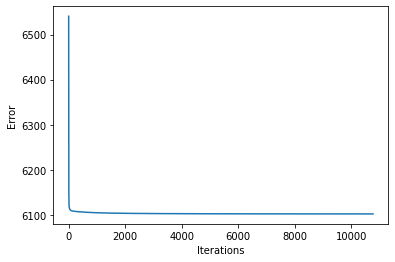

[ 0.04254039 -0.05628443 -0.01701358  0.01511054  0.25975449 -0.02932812
 -0.008126    0.11679783 -0.02343402  0.4317585   0.02555219  0.62238826
  0.13529801 -0.02009821  1.31847569  0.04921831 -0.01193673 -0.06034584
 -0.28971289 -0.13335064  0.15770812 -0.44736205  0.09173054  0.58076585
 -0.92563148  0.05364372  0.10616287  0.15724446 -0.13025941  0.08265132
  0.23819354  0.16263103  0.15821383]
[[2507 1889]
 [1365 4386]]
F score of training data 0.6793140829801911 
Recall of training data 0.7626499739175796
Precision of training data 0.6989641434262949
Accuracy of training data 0.7294195908864127
[[ 624  454]
 [ 346 1113]]
F score of test data 0.6846669294442255 
Recall of test data 0.7628512679917752
Precision of test data 0.7102744097000638
Accuracy of test data 0.735624586913417
Completed in 49.10513191300001


In [48]:
startlr = time.perf_counter()
reg.fit()
endlr = time.perf_counter()

print('Completed in', endlr - startlr)
lr_timer = endlr - startlr

##ROC/AUC

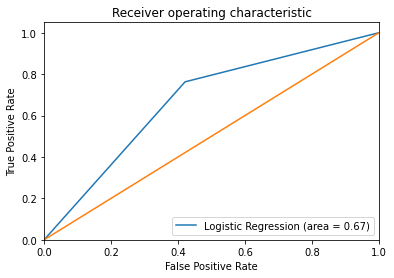

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, reg.predict(X_test_a))
fpr, tpr, thresholds = roc_curve(y_test, reg.predict(X_test_a)[:])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##Gaussian Naive Bayes

In [50]:
class GaussianNaiveBayes:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def distribution(self, data):
        mean = np.mean(data)
        std = np.std(data)
        dist = norm(mean, std)
        
        return dist

    def probability(self, X, prior, probfor):
        prob = prior
        if probfor == 0:
            for i in range(self.X0_train.shape[1]):
                prob *= self.dist_X0[i].pdf(X[i])
        else:
            for i in range(self.X1_train.shape[1]):
                prob *= self.dist_X1[i].pdf(X[i])
        return prob

    def fit(self):
        
        self.X0_train = self.X_train[self.y_train == 0]
        self.X1_train = self.X_train[self.y_train == 1]

        self.prior0 = len(self.X0_train)/len(self.X_train)
        self.prior1 = len(self.X1_train)/len(self.X_train)

        self.dist_X0 = dict()
        self.dist_X1 = dict()

        for i in range(self.X0_train.shape[1]):
            
            self.dist_X0[i] = self.distribution(self.X0_train[i])
            self.dist_X1[i] = self.distribution(self.X1_train[i])
      
    def predict(self):
        self.predictions = []
        for sample, target in zip(self.X_train, self.y_train):
            prob0 = self.probability(sample, self.prior0, 0)
            prob1 = self.probability(sample, self.prior1, 1)

            self.predictions.append(np.argmax([prob0, prob1]))

        f_score, recall, precision, accuracy = evaluate(self.y_train, np.array(self.predictions))
        print('For Training Data')
        print('F1 score of train data {}'.format(f_score))
        print('Recall of train data {}'.format(recall))
        print('Precision of train data {}'.format(precision))
        print('Accuracy of train data {}'.format(accuracy))
        
        self.predictions = []
        for sample, target in zip(self.X_test, self.y_test):
            prob0 = self.probability(sample, self.prior0, 0)
            prob1 = self.probability(sample, self.prior1, 1)

            self.predictions.append(np.argmax([prob0, prob1]))

        f_score, recall, precision, accuracy = evaluate(self.y_test, np.array(self.predictions))
        print('For Test Data')
        print('F1 score of test data {}'.format(f_score))
        print('Recall of test data {}'.format(recall))
        print('Precision of test data {}'.format(precision))
        print('Accuracy of test data {}'.format(accuracy))

In [51]:
nb = GaussianNaiveBayes(X_train_a, y_train1, X_test_a, y_test1)

In [52]:
startnb = time.perf_counter()

nb.fit()
nb.predict()

endnb = time.perf_counter()

print('Completed in', endnb - startnb)

nb_timer = endnb - startnb

[[2270 2126]
 [2322 3429]]
For Training Data
F1 score of train data 0.5616438356164384
Recall of train data 0.596244131455399
Precision of train data 0.6172817281728172
Accuracy of train data 0.6065805766849459
[[527 551]
 [584 875]]
For Test Data
F1 score of test data 0.5526212061489949
Recall of test data 0.5997258396161754
Precision of test data 0.6136044880785414
Accuracy of test data 0.6065857885615251
Completed in 177.20429227200003


## SVM

In [53]:
class SVM():
    def __init__(self, max_iter=100, C=1.0, epsilon=0.001):
        self.max_iter = max_iter
        self.C = C
        self.epsilon = epsilon
    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j)
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = -2 * self.kernel(x_i, x_j) + self.kernel(x_i, x_i) + self.kernel(x_j, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])
            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break
            
            if count >= self.max_iter:
                print("The max of %d iterations has been reached" % (self.max_iter))
                self.support_vectors = X[np.where(alpha > 0)[0], :]
                return
        self.b = self.calc_b(X, y, self.w)
        self.w = self.calc_w(alpha, y, X)

        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        self.support_vectors = X[alpha_idx, :]
        return self.support_vectors, count
    def getsupportvectors(self):
        return self.support_vectors
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def getcoeffintercept(self):
        return self.w, self.b
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    def kernel(self, x1, x2):
        return np.dot(x1, x2.T)
    def predict_proba(self, X):
        return np.dot(self.w.T, X.T) + self.b

In [54]:
startsvm = time.perf_counter()


model = SVM(max_iter=20, C=1.0, epsilon=0.00001)
y_train_svm = []
y_test_svm = []
for i in range(len(y_train1)):
    if(y_train1[i] == 0):
      y_train_svm.append(-1)
    else:
      y_train_svm.append(1)

for i in range(len(y_test1)):
    if(y_test1[i] == 0):
      y_test_svm.append(-1)
    else:
      y_test_svm.append(1)

y_train_svm = np.asarray(y_train_svm)
y_test_svm = np.asarray(y_test_svm)

model.fit(X_train_a, y_train_svm)

Y_predicted = [model.predict(x) for x in X_train_a]
f_score, recall, precision, accuracy = evaluate(y_train_svm, np.array(Y_predicted))
print('F1 score of train data {}'.format(f_score))
print('Recall of train data {}'.format(recall))
print('Precision of train data {}'.format(precision))
print('Accuracy of train data {}'.format(accuracy))

Y_predicted = [model.predict(x) for x in X_test_a]
f_score, recall, precision, accuracy = evaluate(y_test_svm, np.array(Y_predicted))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))

endsvm = time.perf_counter()

print('Completed in', endsvm - startsvm)
svm_timer = endsvm - startsvm

The max of 20 iterations has been reached
[[2517 1879]
 [2121 3630]]
F1 score of train data 0.6057948162018331
Recall of train data 0.6311945748565467
Precision of train data 0.658921764385551
Accuracy of train data 0.6447602131438721
[[635 443]
 [534 925]]
F1 score of test data 0.6148994875837603
Recall of test data 0.6339958875942426
Precision of test data 0.6761695906432749
Accuracy of test data 0.6544039617969579
Completed in 201.29620367300004


##KNN

In [55]:
import numpy as np
from scipy.stats import mode
 
def eucledian(d1,d2):
    dis = np.sqrt(np.sum((d1-d2)**2))
    return dis
 

def predictKNN(X_train, y , X_input, k):
    op_labels = []
     

    for item in X_input: 
         
        p_dist = []
         
        for j in range(len(X_train)): 
            distances = eucledian(np.array(X_train[j,:]) , item) 
            p_dist.append(distances) 
        p_dist = np.array(p_dist) 
         
        dist = np.argsort(p_dist)[:k] 
         
        labels = y[dist]
         
        lab = mode(labels) 
        lab = lab.mode[0]
        op_labels.append(lab)
 
    return op_labels

In [56]:
startknn = time.perf_counter()


from numpy.random import randint
 

idx = randint(0,150,1000)
X_train_sam = X_train_a[idx]
y_train_sam = y_train1[idx]

X_test_sam = X_test_a[idx]
y_test_sam = y_test1[idx]
 
y_pred = predictKNN(X_train_sam,y_train_sam,X_test_sam , 14)

f_score, recall, precision, accuracy = evaluate(y_train_sam, np.array(y_pred).astype('int64'))
print('F1 score of train data {}'.format(f_score))
print('Recall of train data {}'.format(recall))
print('Precision of train data {}'.format(precision))
print('Accuracy of train data {}'.format(accuracy))


f_score, recall, precision, accuracy = evaluate(y_test_sam, np.array(y_pred).astype('int64'))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))


endknn = time.perf_counter()

print('Completed in', endknn - startknn)

knn_timer = endknn - startknn

[[114 232]
 [203 451]]
F1 score of train data 0.565
Recall of train data 0.6896024464831805
Precision of train data 0.6603221083455344
Accuracy of train data 0.674644727000748
[[154 264]
 [163 419]]
F1 score of test data 0.573
Recall of test data 0.7199312714776632
Precision of test data 0.6134699853587116
Accuracy of test data 0.6624505928853756
Completed in 35.40986431400006


##NN

In [57]:
#importing libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [58]:
#Defining our sequential model
nn = Sequential()

#
nn.add(Dense(64, input_shape=(X_train_a.shape[1],), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(16, activation='sigmoid'))
nn.add(Dense(1))

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2176      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [59]:
nn.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [60]:
startnn = time.perf_counter()

EPOCHS = 20
BATCH_SIZE = 10
history = nn.fit(X_train_a, y_train1, validation_data=(X_test_a, y_test1), epochs=EPOCHS, batch_size=BATCH_SIZE)



endnn = time.perf_counter()

print('Completed in', endnn - startnn)

nn_timer = endnn - startnn

Epoch 1/20
1015/1015 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.6262 - val_loss: 0.6121 - val_accuracy: 0.6460
Epoch 2/20
1015/1015 [==============================] - 3s 3ms/step - loss: 0.6090 - accuracy: 0.6681 - val_loss: 0.5878 - val_accuracy: 0.6941
Epoch 3/20
1015/1015 [==============================] - 3s 3ms/step - loss: 0.5950 - accuracy: 0.6789 - val_loss: 0.5861 - val_accuracy: 0.6795
Epoch 4/20
1015/1015 [==============================] - 3s 3ms/step - loss: 0.5885 - accuracy: 0.6862 - val_loss: 0.5721 - val_accuracy: 0.7044
Epoch 5/20
1015/1015 [==============================] - 3s 3ms/step - loss: 0.5854 - accuracy: 0.6891 - val_loss: 0.5749 - val_accuracy: 0.6819
Epoch 6/20
1015/1015 [==============================] - 3s 3ms/step - loss: 0.5803 - accuracy: 0.6964 - val_loss: 0.5735 - val_accuracy: 0.7186
Epoch 7/20
1015/1015 [==============================] - 3s 3ms/step - loss: 0.5759 - accuracy: 0.7001 - val_loss: 0.5677 - val_accuracy:

Plotting epoch vs accuracy/loss

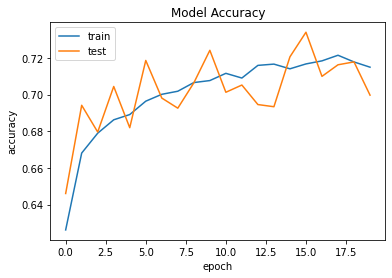

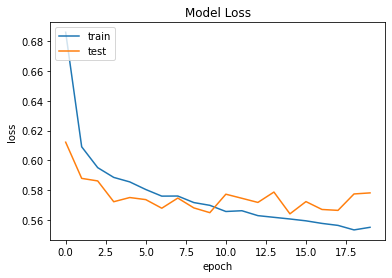

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
nn_accuracy = max(history.history['accuracy'])
nn_accuracy

0.7213954925537109

In [63]:
nn_accuracy_test = max(history.history['val_accuracy'])
nn_accuracy_test

0.7339377403259277

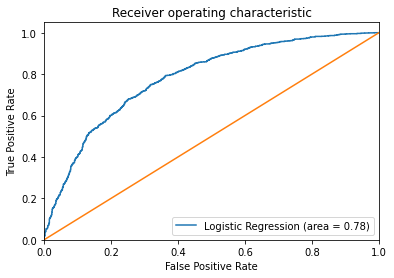

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, nn.predict(X_test_a))
fpr, tpr, thresholds = roc_curve(y_test, nn.predict(X_test_a)[:])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##Approach B

In [65]:
X_train_b = X_train.copy()
X_test_b = X_test.copy()


In [66]:
num_features_b = X_train_b.select_dtypes(['int64', 'float64']).columns
cat_features_b = X_train_b.select_dtypes(['object']).columns

preprocessor_b = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features_b),
    ('cat', cat_transformer, cat_features_b)
])
X_train_b = preprocessor_b.fit_transform(X_train_b)
X_test_b = preprocessor_b.transform(X_test_b)

In [67]:
X_train_b, X_test_b=X_train_b.toarray(),X_test_b.toarray()


##Logistic Regression

In [68]:
reg2 = LogisticRegression(X_train_b, X_test_b, y_train, y_test, learningRate = 0.0001, tolerance = 0.00001, maxIteration = 25000)

 12%|█▏        | 2912/25000 [00:25<03:11, 115.50it/s]


Model has stopped learning


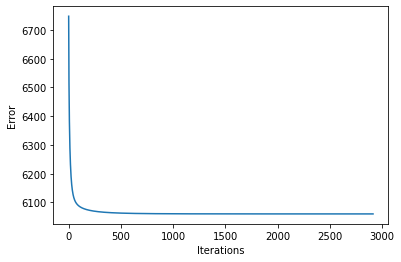

[ 6.97249842e-03 -4.99522721e-02 -3.19204287e-03  1.47802537e-02
  2.86087224e-01 -3.92660583e-02 -1.91748202e-04  1.12368105e-01
  9.35550208e-03 -2.61439909e-01  4.20428206e-01 -1.25002003e-01
 -2.27822014e-02  1.91119036e-01 -3.88748465e-01  2.54397923e-01
 -2.94029106e-02 -2.74175945e-01  3.37565148e-01  3.96977793e-02
 -1.66525628e-01  1.58835044e-02  2.69932641e-01 -1.25002003e-01
 -7.63916954e-01  7.99006480e-01 -2.72188903e-01 -4.27685066e-01
  6.98770736e-01  4.35967989e-01 -4.01981696e-01 -6.20535515e-02
  9.60398445e-02 -1.71533386e-01  4.83739108e-02  2.61414147e-01
  4.17900667e-02 -1.46058446e-01 -2.50465307e-02  5.90328236e-02
 -4.51550833e-02 -1.58407165e-01 -3.76325533e-01  1.27072241e-02
  6.14536929e-01 -1.33700790e-02  3.44339821e-01 -2.95607124e-01
  2.33069637e-01 -8.53281885e-02 -3.11288901e-01 -8.78261708e-02
  7.05038797e-01 -2.04665947e-01 -9.10127606e-02 -6.70960602e-02
  6.53862437e-01  4.91715562e-01 -4.76173668e-01 -5.67312625e-01
  2.04163486e-01 -7.16748

In [69]:
startlr2 = time.perf_counter()
reg2.fit()
endlr2 = time.perf_counter()

print('Completed in', endlr2 - startlr2)
lr_timer2 = endlr2 - startlr2

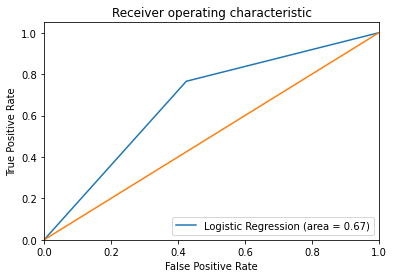

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, reg2.predict(X_test_b))
fpr, tpr, thresholds = roc_curve(y_test, reg2.predict(X_test_b)[:])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##SVM

In [71]:
startsvm = time.perf_counter()


model2 = SVM(max_iter=10, C=1.0, epsilon=0.00001)
y_train_svm = []
y_test_svm = []
for i in range(len(y_train1)):
    if(y_train1[i] == 0):
      y_train_svm.append(-1)
    else:
      y_train_svm.append(1)

for i in range(len(y_test1)):
    if(y_test1[i] == 0):
      y_test_svm.append(-1)
    else:
      y_test_svm.append(1)

y_train_svm = np.asarray(y_train_svm)
y_test_svm = np.asarray(y_test_svm)

model2.fit(X_train_b, y_train_svm)

Y_predicted = [model2.predict(x) for x in X_train_b]
f_score, recall, precision, accuracy = evaluate(y_train_svm, np.array(Y_predicted))
print('F1 score of train data {}'.format(f_score))
print('Recall of train data {}'.format(recall))
print('Precision of train data {}'.format(precision))
print('Accuracy of train data {}'.format(accuracy))

Y_predicted = [model2.predict(x) for x in X_test_b]
f_score, recall, precision, accuracy = evaluate(y_test_svm, np.array(Y_predicted))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))

endsvm = time.perf_counter()

print('Completed in', endsvm - startsvm)
svm_timer = endsvm - startsvm

The max of 10 iterations has been reached
[[2572 1824]
 [1966 3785]]
F1 score of train data 0.6264905883512368
Recall of train data 0.6581464093201183
Precision of train data 0.6748083437332858
Accuracy of train data 0.6663732394366197
[[635 443]
 [519 940]]
F1 score of test data 0.6208119826566811
Recall of test data 0.6442769019876627
Precision of test data 0.6796818510484454
Accuracy of test data 0.661505981703026
Completed in 132.45774942799994


##NN

In [72]:
nn2 = Sequential()

#
nn2.add(Dense(64, input_shape=(X_train_b.shape[1],), activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
nn2.add(Dense(32, activation='relu'))
nn2.add(Dense(16, activation='sigmoid'))
nn2.add(Dense(1))

nn2.summary()

nn2.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

startnn2 = time.perf_counter()
EPOCHS = 20
BATCH_SIZE = 10
history = nn2.fit(X_train_b, y_train1, validation_data=(X_test_b, y_test1), epochs=EPOCHS, batch_size=BATCH_SIZE)



endnn2 = time.perf_counter()

print('Completed in', endnn2 - startnn2)

nn_timer2 = endnn2 - startnn2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                4736      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1015/1015 [==============================] - 4s 3ms/step - loss: 0.7068 - accuracy: 0.6144 - val_loss: 0.6164 - val_accuracy: 0.6681
Epoch 2/20
1015/1015 [==================

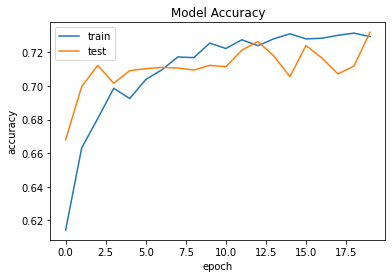

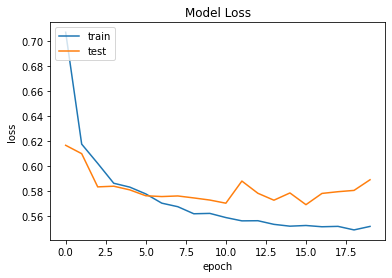

In [73]:
#Plotting model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
nn_accuracy = max(history.history['accuracy'])
nn_accuracy

0.731447696685791

In [75]:
nn_accuracy_test = max(history.history['val_accuracy'])
nn_accuracy_test

0.7319669127464294

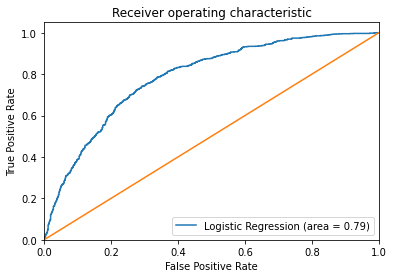

In [76]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, nn2.predict(X_test_b))
fpr, tpr, thresholds = roc_curve(y_test, nn2.predict(X_test_b)[:])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

##KNN

In [77]:
startknn2 = time.perf_counter()


from numpy.random import randint
 
#Creating the training Data
idx = randint(0,150,1000)
X_train_sam = X_train_b[idx]
y_train_sam = y_train1[idx]

X_test_sam = X_test_b[idx]
y_test_sam = y_test1[idx]
 
#Applying our function 
y_pred = predictKNN(X_train_sam,y_train_sam,X_test_sam , 10)

f_score, recall, precision, accuracy = evaluate(y_train_sam, np.array(y_pred).astype('int64'))
print('F1 score of train data {}'.format(f_score))
print('Recall of train data {}'.format(recall))
print('Precision of train data {}'.format(precision))
print('Accuracy of train data {}'.format(accuracy))


f_score, recall, precision, accuracy = evaluate(y_test_sam, np.array(y_pred).astype('int64'))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))


endknn2 = time.perf_counter()

print('Completed in', endknn2 - startknn2)

knn_timer = endknn2 - startknn2

[[128 237]
 [197 438]]
F1 score of train data 0.566
Recall of train data 0.6897637795275591
Precision of train data 0.6488888888888888
Accuracy of train data 0.6687022900763359
[[169 256]
 [156 419]]
F1 score of test data 0.588
Recall of test data 0.7286956521739131
Precision of test data 0.6207407407407407
Accuracy of test data 0.6704
Completed in 16.001556875000006


SVM

In [78]:
startsvm2 = time.perf_counter()


model2 = SVM(max_iter=20, C=1.0, epsilon=0.00001)
y_train_svm = []
y_test_svm = []
for i in range(len(y_train1)):
    if(y_train1[i] == 0):
      y_train_svm.append(-1)
    else:
      y_train_svm.append(1)

for i in range(len(y_test1)):
    if(y_test1[i] == 0):
      y_test_svm.append(-1)
    else:
      y_test_svm.append(1)

y_train_svm = np.asarray(y_train_svm)
y_test_svm = np.asarray(y_test_svm)

model2.fit(X_train_b, y_train_svm)

Y_predicted = [model2.predict(x) for x in X_train_b]
f_score, recall, precision, accuracy = evaluate(y_train_svm, np.array(Y_predicted))
print('F1 score of train data {}'.format(f_score))
print('Recall of train data {}'.format(recall))
print('Precision of train data {}'.format(precision))
print('Accuracy of train data {}'.format(accuracy))

Y_predicted = [model2.predict(x) for x in X_test_b]
f_score, recall, precision, accuracy = evaluate(y_test_svm, np.array(Y_predicted))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))

endsvm2 = time.perf_counter()

print('Completed in', endsvm2 - startsvm2)
svm_timer = endsvm2 - startsvm2

The max of 20 iterations has been reached
[[2794 1602]
 [1732 4019]]
F1 score of train data 0.6714299793042279
Recall of train data 0.6988349852199618
Precision of train data 0.7149973314356876
Accuracy of train data 0.706823777699613
[[ 701  377]
 [ 448 1011]]
F1 score of test data 0.6748127709893575
Recall of test data 0.6929403701165182
Precision of test data 0.728386167146974
Accuracy of test data 0.7102212855637514
Completed in 175.8082392209999


## Gaussian Naive Bayes

In [79]:
nb2 = GaussianNaiveBayes(X_train_b, y_train1, X_test_b, y_test1)

In [80]:
startnb2 = time.perf_counter()

nb2.fit()
nb2.predict()

endnb2 = time.perf_counter()

print('Completed in', endnb2 - startnb2)

nb_timer = endnb2 - startnb2

[[2078 2318]
 [3007 2744]]
For Training Data
F1 score of train data 0.47521434906869026
Recall of train data 0.47713441140671187
Precision of train data 0.5420782299486369
Accuracy of train data 0.5075372237121981
[[530 548]
 [777 682]]
For Test Data
F1 score of test data 0.4777296018919984
Recall of test data 0.4674434544208362
Precision of test data 0.5544715447154471
Accuracy of test data 0.5072517664559316
Completed in 391.299024488
